TODOs:
    1. Encode data without losing too much info

In [272]:
import random
import librosa
import soundfile
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.decomposition import PCA

In [273]:
def cut_audio(audio, seq_len):
    if audio.size >= seq_len:
        max_audio_start = audio.size - seq_len
        audio_start = random.randint(0, max_audio_start)
        audio = audio[audio_start : audio_start + seq_len]
    return audio

def rescale_audio(audio):
    mini, maxi = min(audio), max(audio)
    return (audio - mini) / (maxi - mini)

def read_wav_file(file_path, sample_rate=22050, seq_len=8192 * 12):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    audio = cut_audio(audio, seq_len)
    audio = librosa.util.normalize(audio)
    return audio, sr

In [278]:
def mae(y, y_hat):
    return np.mean(((y-y_hat) ** 2) ** 0.5)

def plot_audio(y, y_hat):
    error = mae(y, y_hat)
    plt.plot(y)
    plt.plot(y_hat, alpha=0.25, c='red')
    plt.title(f'MAE - {error}')
    plt.show()

In [275]:
# Need one of them files to test algorithms 

wav_sample_path = './data/jazz_classical/jazz/jazz.00005.wav'
audio, _ = read_wav_file(wav_path)

# Encoding using Short-time Fourier Transform

In [276]:
def audio_to_sft(audio):
    X = librosa.stft(audio)
    specto = librosa.amplitude_to_db(abs(X))
    return specto

def sft_to_audio(specto):
    X_hat = librosa.db_to_amplitude(specto)
    audio = librosa.istft(X_hat)
    return audio

def audio_to_sft(audio):
    X = librosa.stft(audio, n_fft=1024, hop_length=256, win_length=1024)
    specto = librosa.amplitude_to_db(abs(X), top_db=None)
    return specto

def sft_to_audio(specto):
    X_hat = librosa.db_to_amplitude(specto)
    audio = librosa.istft(X_hat, hop_length=256, win_length=1024)
    return audio

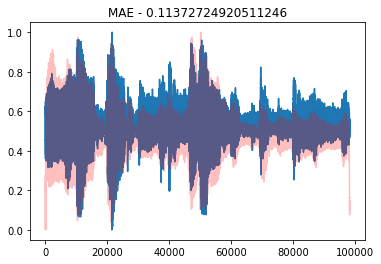

In [277]:
audio_sft_res = rescale_audio(audio)
specto = audio_to_sft(audio_sft_res)
audio_sft_hat = rescale_audio(sft_to_audio(specto))

plot_audio(audio_sft_res, audio_sft_hat)

write_wav_file('audio_sft_res.wav', audio_sft_res)
write_wav_file('audio_sft_hat.wav', audio_sft_hat)

# Encoding using PCA

In [318]:
def compute_PCA(dataset):
    pca = PCA(0.99).fit(dataset)
    components = pca.transform(dataset)
    projected = pca.inverse_transform(components)
    print(components.shape)
    
    rnd_idx = random.randint(0, len(dataset)-1)
    pca_input  = dataset[rnd_idx]
    pca_output = projected[rnd_idx]
    
    return pca

In [319]:
def error_distribution(dataset, pca):
    components = pca.transform(dataset)
    projected = pca.inverse_transform(components)
    
    errors = []
    max_error = 0 
    max_error_idx = -1
    for idx in range(len(dataset)):
        pca_input  = dataset[idx]
        pca_output = projected[idx]
        error = mae(pca_input, pca_output)
        if error > max_error:
            max_error = error
            big_error_idx = idx
        errors.append(error)
        
    fig, axs = plt.subplots(2, 1, figsize=(8,8))
    axs[0].hist(errors)
    axs[1].plot(dataset[big_error_idx])
    axs[1].plot(projected[big_error_idx], alpha=0.25, color='red')
    plt.show()

In [320]:
dataset = []
# we can go multiple times in the dataset and extract different slices
for _ in range(20): 
    for wav_path in Path('./data/jazz_classical/jazz').glob('*.wav'):
        audio, _ = read_wav_file(wav_path)
        dataset.append([audio])
dataset = np.concatenate(dataset)

(1980, 1862)


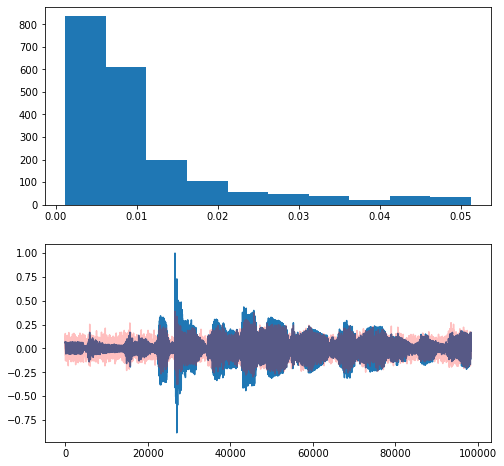

In [321]:
pca = compute_PCA(dataset)
error_distribution(dataset, pca)

# Encoding data using Wavelet and PCA

In [322]:
import pywt

def audio_to_wavelet(audio):
    db1 = pywt.Wavelet('db1')
    return pywt.wavedec(audio, db1, mode='constant', level=2)

def wavelet_to_audio(wavelet):
    db1 = pywt.Wavelet('db1')
    return pywt.waverec(wavelet, db1)

In [323]:
dataset_cA2, dataset_cD2, dataset_cD1 = [], [], []
for audio in dataset:
    cA2, cD2, cD1 = audio_to_wavelet(audio)
    dataset_cA2.append([cA2])
    dataset_cD2.append([cD2])
    dataset_cD1.append([cD1])

dataset_cA2 = np.concatenate(dataset_cA2)
dataset_cD2 = np.concatenate(dataset_cD2)
dataset_cD1 = np.concatenate(dataset_cD1)

(1980, 1851)


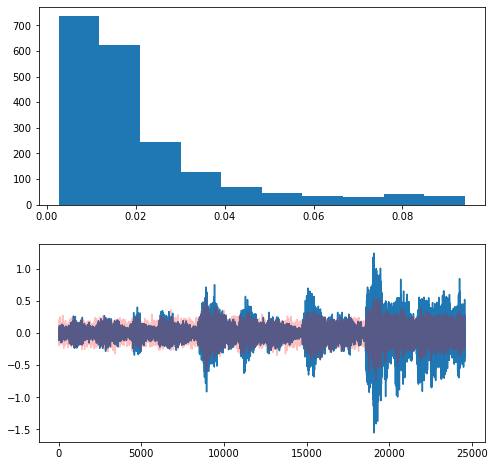

(1980, 1806)


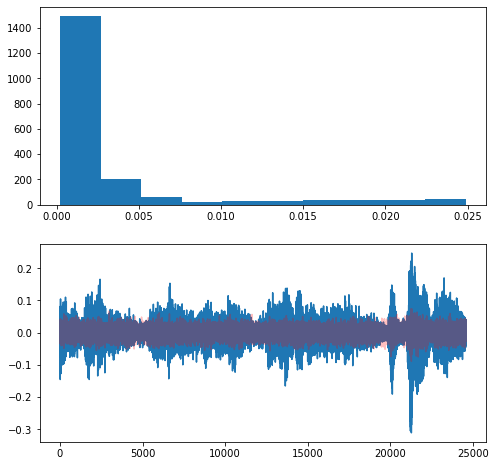

(1980, 1778)


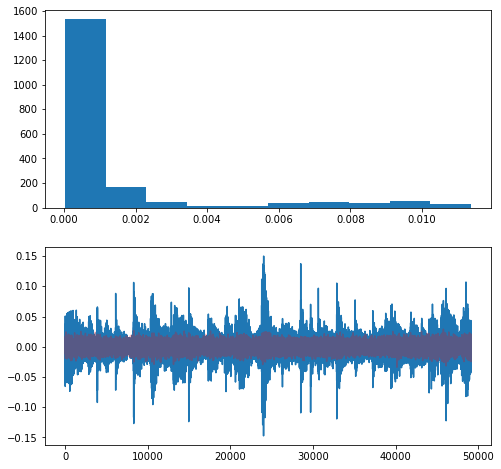

In [324]:
pca_lst = []
for dataset in [dataset_cA2, dataset_cD2, dataset_cD1]:
    pca_wl = compute_PCA(dataset)
    error_distribution(dataset, pca_wl)
    pca_lst.append(pca_wl)